## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys, shutil
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random

In [3]:
sys.path.insert(0, "../")
from utils.DLutils import *
from utils.vizutils import *
from create_toybrains import ToyBrainsData
from experiments.fit_DL_model import *

/ritter/roshan/installation/miniforge3/envs/drv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
DEEPREPVIZ_REPO = "../../Deep-confound-control-v2/"
sys.path.append(DEEPREPVIZ_REPO)
from DeepRepViz import *

In [5]:
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger, WandbLogger

In [6]:
import logging
# disable some unneccesary lightning warnings
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

First, generate the toybrain datasets 

Refer to the notebook `toybrains/experiments/gen_lbl1cov1_configs.ipynb` for an example on how to generate the dataset.
Alternatively, if you have a config such as `configs.lbl1cov1` you can simply run,
```bash
! nohup python3 create_toybrains.py -c configs.lbl1cov1 -n 10000 --suffix n &> nohup1.out &
```

In [7]:
base_config_file = "configs/lblmidr_covsite/lblmidr_covsite_t0.py"

DATASETS = sorted([os.path.abspath(path) for path in glob("../dataset/toybrains_n10000_lblmidr_covsite_t*")])
print("Fitting DL model on the following toybrains datasets:")
DATASETS

Fitting DL model on the following toybrains datasets:


['/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t0',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t1',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t2',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t3',
 '/ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t4']

### Generative attr. dist.

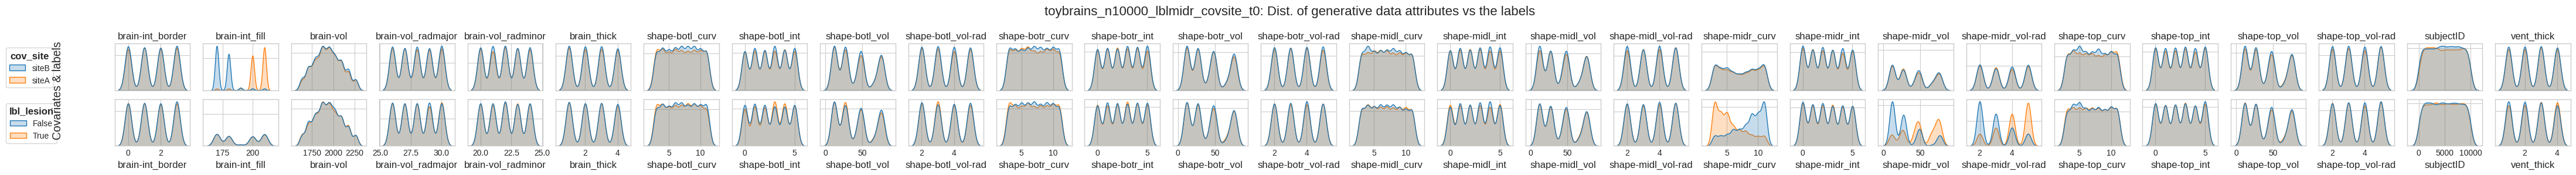

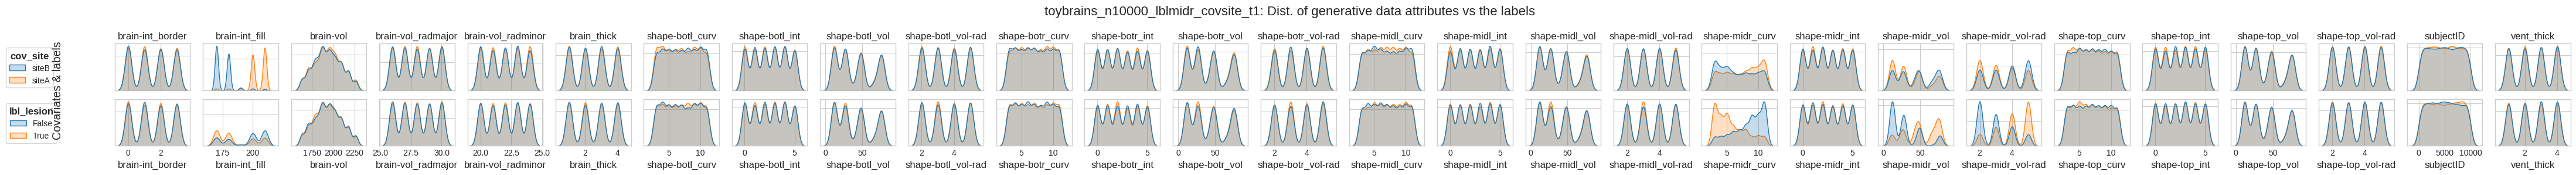

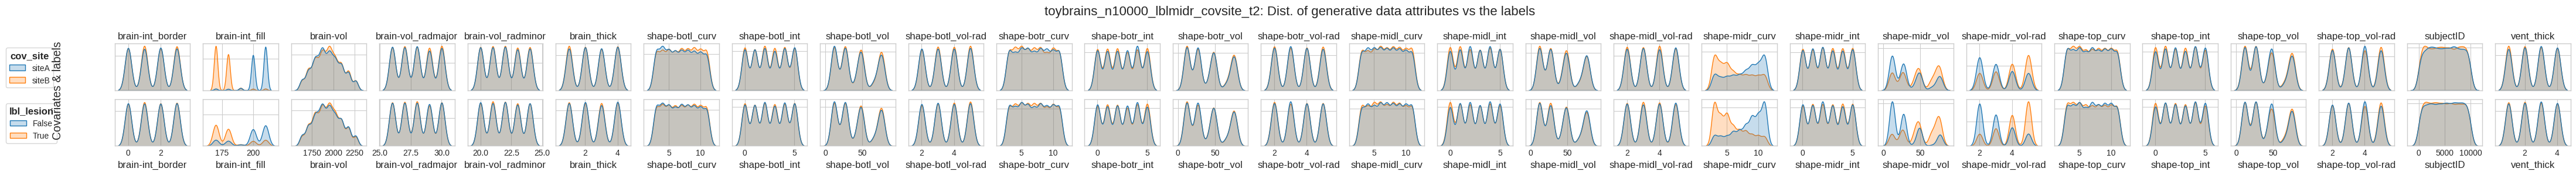

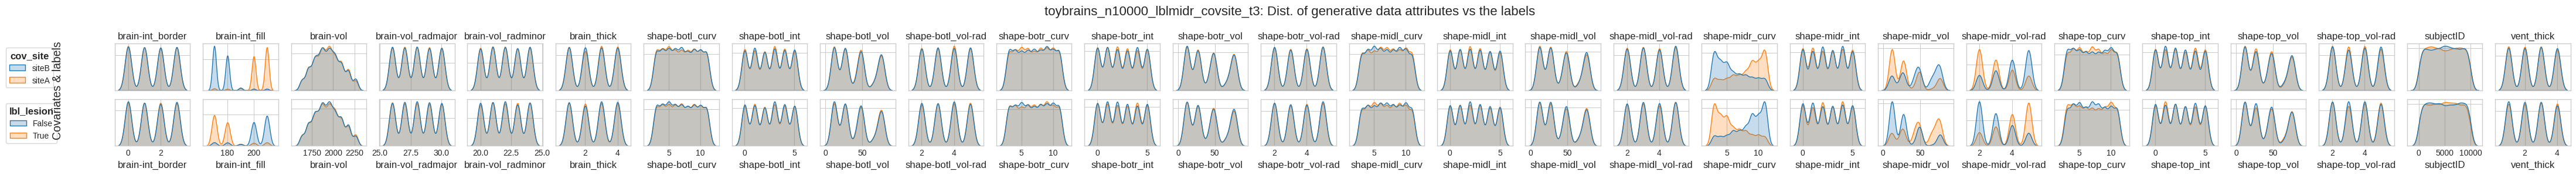

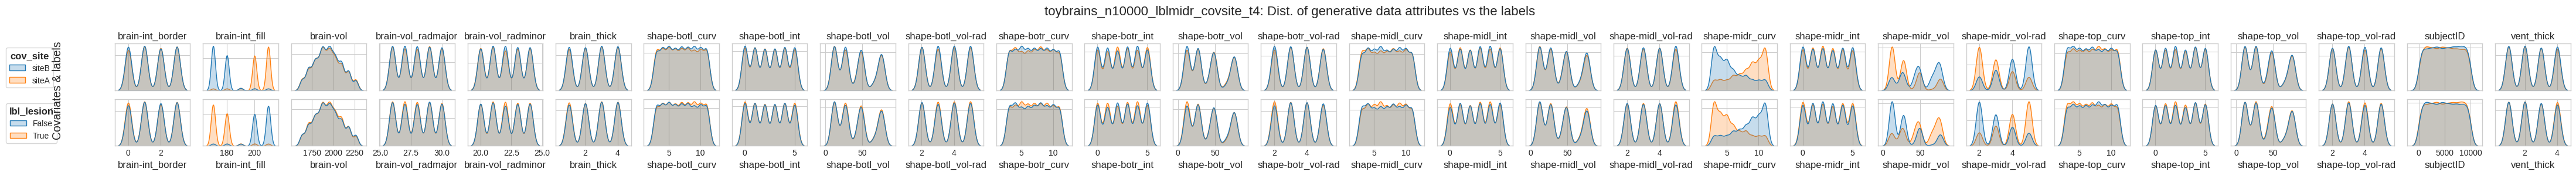

In [8]:
for data_dir in DATASETS:
    data_name = data_dir.split('/')[-1]
    df = pd.read_csv(f'{data_dir}/{data_name}.csv')
    cov_cols = df.filter(regex='^(cov_|lbl_)').columns
    attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
    plot_col_dists(df, 
                   attr_cols=attr_cols, cov_cols=cov_cols, 
                   title=f"{data_name}: Dist. of generative data attributes vs the labels")
    plt.show()

### Baseline attr. accuracies

In [9]:
results = []
for data_dir in DATASETS:
    toy = ToyBrainsData(base_config_file)
    # load the already generated dataset
    toy.load_generated_dataset(data_dir)
    result = toy.fit_baseline_models(CV=10) 
    results.append(result)

running a total of 90 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t0


100%|██████████| 90/90 [00:11<00:00,  7.83it/s]


TOTAL RUNTIME: 0:00:12
running a total of 90 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t1


100%|██████████| 90/90 [00:05<00:00, 15.97it/s]


TOTAL RUNTIME: 0:00:07
running a total of 90 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t2


100%|██████████| 90/90 [00:05<00:00, 15.82it/s]


TOTAL RUNTIME: 0:00:07
running a total of 90 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t3


100%|██████████| 90/90 [00:05<00:00, 15.96it/s]


TOTAL RUNTIME: 0:00:07
running a total of 90 different settings of [input] x [output] x [CV] and saving result in /ritter/roshan/workspace/toybrains/dataset/toybrains_n10000_lblmidr_covsite_t4


100%|██████████| 90/90 [00:05<00:00, 15.45it/s]


TOTAL RUNTIME: 0:00:07


### Estimation using Model performance

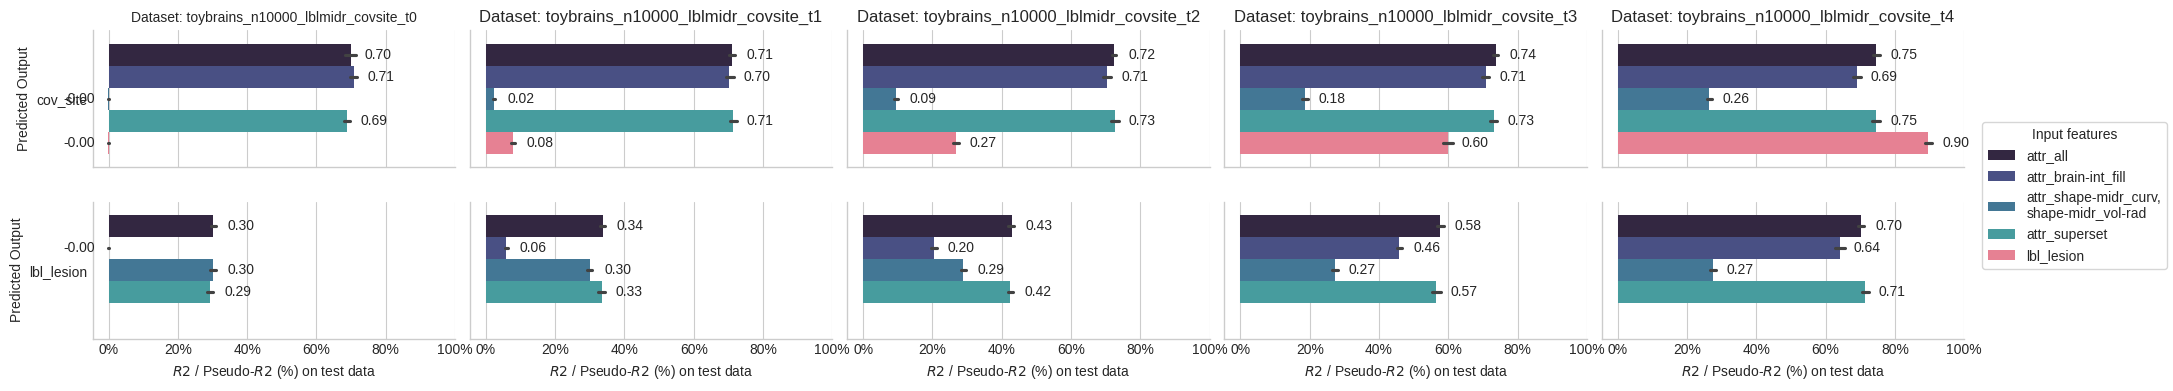

In [10]:
viz_baseline_results(results)

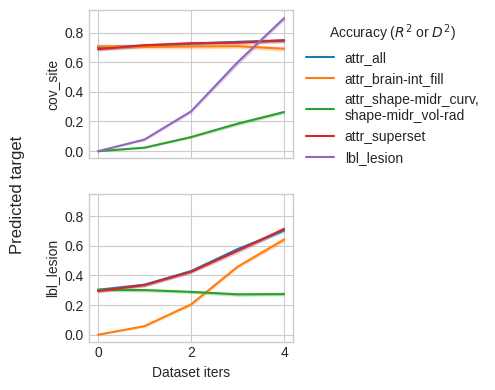

In [11]:
viz_baseline_results_summary(results)

#### collect the results in a dataframe

In [12]:
df_baseline = pd.concat(results)

In [28]:
grp_by_cols = ['dataset', 'inp']
signal_col = 'test_metric'
df_baseline_temp = df_baseline.loc[df_baseline.out.apply(lambda x: 'lbl_' in x).values, grp_by_cols+[signal_col]]
df_baseline_temp = df_baseline_temp.groupby(grp_by_cols).mean().reset_index()
df_baseline_temp.inp = df_baseline_temp.inp.map({'attr_all':r'$S_{total}$', 
                                                 'attr_superset':r'$S_{total}$ (less noise)', 
                                                 'attr_shape-midr_curv, shape-midr_vol-rad':r'$S_{y}$',
                                                 'attr_brain-int_fill':r'$S_{conf}$'})

In [29]:
df_final = {}
cols = []
for dataset, dfi in df_baseline_temp.groupby("dataset"):
    dfi = dfi[['inp','test_metric']].T
    dfi.columns = dfi.loc['inp'].values
    dfi = dfi.drop(index='inp')
    if not len(cols): 
        cols = dfi.columns
    vals = [dfi[c].values[0] for c in cols]
    df_final.update({dataset: vals})
    
df_final = pd.DataFrame.from_dict(df_final, orient='index', columns=cols)
df_final.index.name = 'Dataset'
df_final.index = df_final.index.str.split('/').str[-1]
df_final.style.bar(vmin=0, vmax=1)

,$S_{total}$,$S_{conf}$,$S_{y}$,$S_{total}$ (less noise)
Dataset,,,,
toybrains_n10000_lblmidr_covsite_t0,0.302613,-0.000259,0.302129,0.293941
toybrains_n10000_lblmidr_covsite_t1,0.336885,0.057928,0.301027,0.334214
toybrains_n10000_lblmidr_covsite_t2,0.428743,0.204139,0.288953,0.424715
toybrains_n10000_lblmidr_covsite_t3,0.576491,0.458018,0.272185,0.565280
toybrains_n10000_lblmidr_covsite_t4,0.702704,0.641201,0.273961,0.713442


### Estimation using SHAP

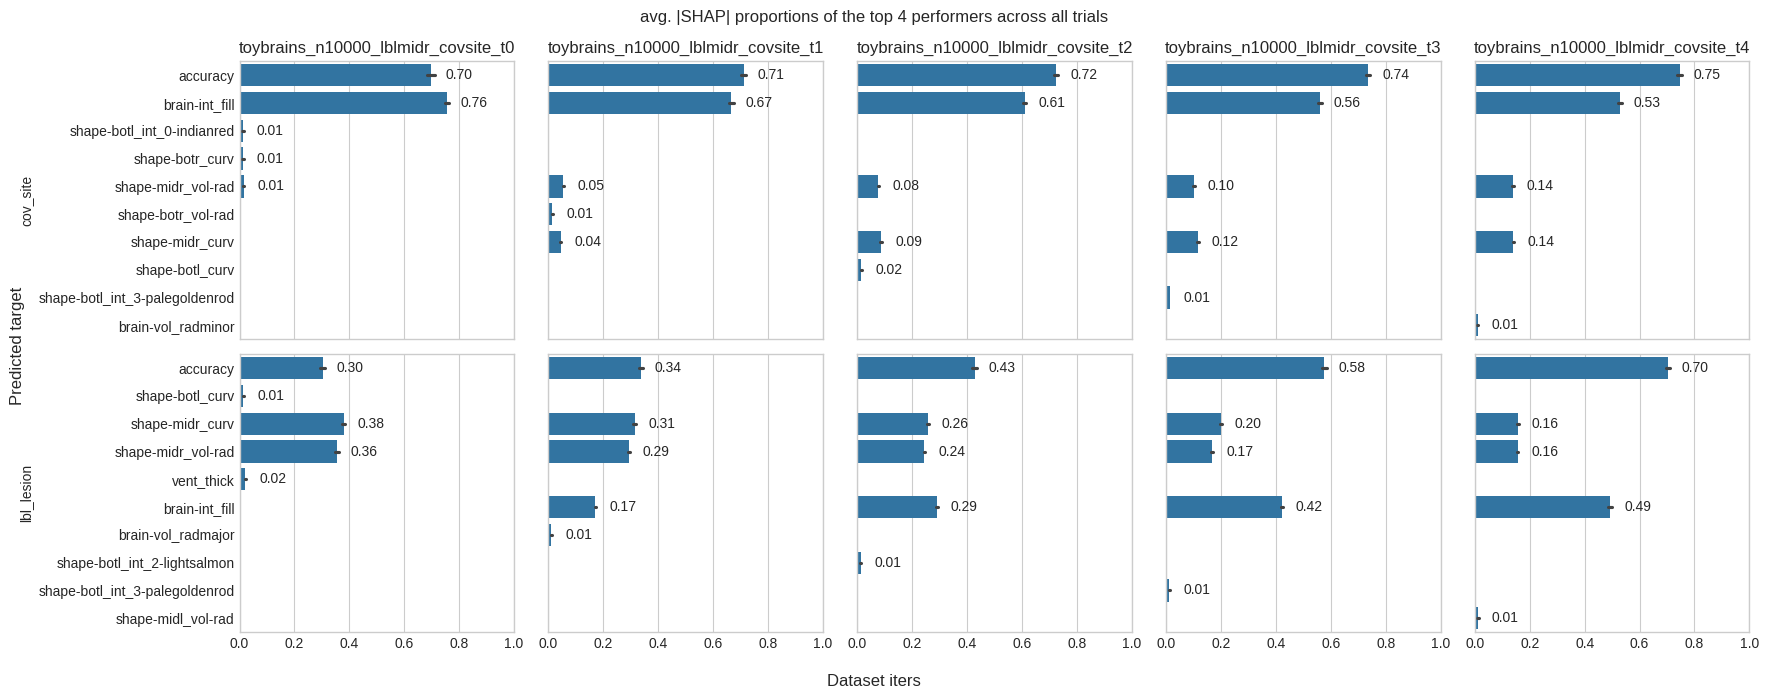

In [16]:
viz_baseline_results_shap(results)